In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import warnings
warnings.filterwarnings('ignore')

# Підвищимо розмір графіків за замовчуванням
# plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'
# plt.rcParams['figure.figsize'] = 7, 5
# plt.rcParams['axes.grid'] = True


In [2]:
# define emotion classes
EMOTIONS = ['Злість', 'Огида', 'Страх', 'Радість', 'Нейтр', 'Сум', 'Подив']

# path to output images
DATASET_NAME = 'fer'
PALETTE_BARPLOT = 'Greens'
PALETTE_HEATMAP = 'Greens'
FOLDER_BARPLOT = 'fer_barplots'
FOLDER_HEATMAP = 'fer_heatmaps'

# sheet names
SHEET_NAMES = ['Sheet1', 'Sheet2', 'Sheet3', 'Sheet4', 'Sheet5']

# dictionary to hold arrays
input_matrices = {}

# read each sheet and convert to numpy array
for i, sheet in enumerate(SHEET_NAMES, start=1):
    df = pd.read_excel('er_experiments.xlsx', sheet_name=sheet)
    input_matrices[f'Модель_{i}'] = df.to_numpy()

# access the numpy array for a specific matrix
# print(input_matrices)


In [3]:
# dataframe to hold the results
df_results = pd.DataFrame()

# iterate over each confusion matrix
for matrix_name, A in input_matrices.items():

    # calculate accuracy
    accuracy = np.trace(A) / np.sum(A)

    # flatten the matrix for sklearn metrics
    y_true = np.repeat(np.arange(A.shape[0]), np.sum(A, axis=1))
    y_pred = np.repeat(np.arange(A.shape[0]), np.sum(A, axis=0))

    # calculate precision, recall and f1-score independently for each class
    precision = precision_score(y_true, y_pred, average=None)
    recall = recall_score(y_true, y_pred, average=None)
    f_score = f1_score(y_true, y_pred, average=None)

    # create a dataframe from the metrics
    df = pd.DataFrame({
        'Emotion': EMOTIONS,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f_score
    })

    # add accuracy column (same value for each class)
    df['Accuracy'] = accuracy

    # add matrix name column
    df['Matrix'] = matrix_name

    # append this dataframe to the results dataframe
    df_results = df_results.append(df, ignore_index=True)

# set the Matrix and Emotion columns as the index
# df_results.set_index(['Matrix', 'Emotion', 'Precision', 'Recall', 'F1-Score', 'Accuracy'], inplace=True)

# Save the DataFrame to an Excel file
# df_results.to_excel('df_results.xlsx')

# Save the DataFrame to a csv file
df_results.to_csv('df_results.csv')

# print the dataframe
# df_results


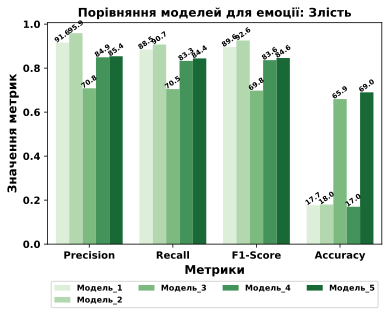

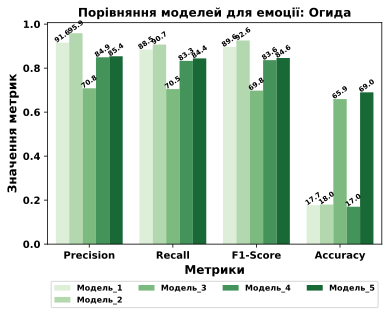

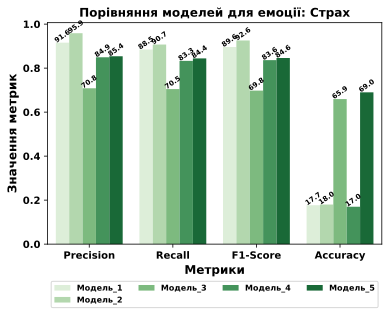

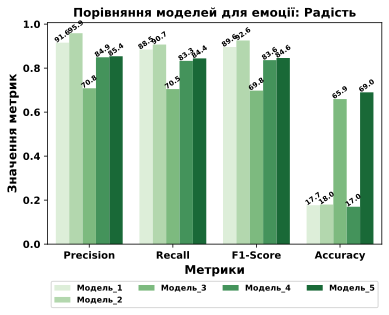

In [ ]:
# get unique emotions
emotions = df_results['Emotion'].unique()

# loop over each emotion
for emotion in emotions:
    # filter rows for the current emotion
    emotion_data = df_results[df_results['Emotion'] == emotion]

    # melt the DataFrame to long format for easy plotting with seaborn
    # emotion_data_melt = pd.melt(emotion_data, id_vars=['Matrix', 'Emotion'],
    #                             value_vars=['Precision', 'Recall', 'F1-Score', 'Accuracy'])
    
    emotion_data_melt = df_results.melt(id_vars=['Matrix', 'Emotion'], var_name='Metrics', value_name='Values')
    
    # plot the data
    plt.figure(figsize=(6,4), dpi=600)
    plt.rcParams.update({
        'font.size': 10,
        'font.weight': 'bold'})
    
    # sns.set_context("paper", font_scale=2)
    barplot = sns.barplot(x='Metrics', y='Values', hue='Matrix', ci=None, 
                          data=emotion_data_melt, 
                          palette=PALETTE_BARPLOT)

    # add title and labels
    plt.title(f'Порівняння моделей для емоції: {emotion}', fontweight='bold', fontsize=12)
    plt.ylabel('Значення метрик', fontweight='bold', fontsize=12)
    plt.xlabel('Метрики', fontweight='bold', fontsize=12)

    # move the legend to an empty part of the plot
    plt.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', 
               ncol=4, fontsize=8)
    
    for p in barplot.patches:
        height = p.get_height()
        barplot.text(x = p.get_x()+(p.get_width()/2),
                     y = height,
                     s = '{:.1f}'.format(height*100),
                     ha = 'center',
                     rotation=35, 
                     fontsize=7)
    
    # check if the folder exists
    if not os.path.exists(FOLDER_BARPLOT):
        os.makedirs(FOLDER_BARPLOT)
    
    # save the plot
    plt.savefig(f'{FOLDER_BARPLOT}/{DATASET_NAME}_bp_{emotion}.svg', 
                format='svg', bbox_inches='tight')
    
    # show the plot
    plt.show()


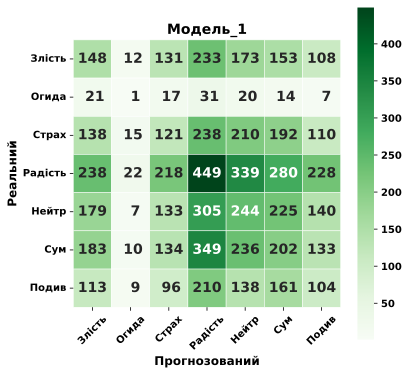

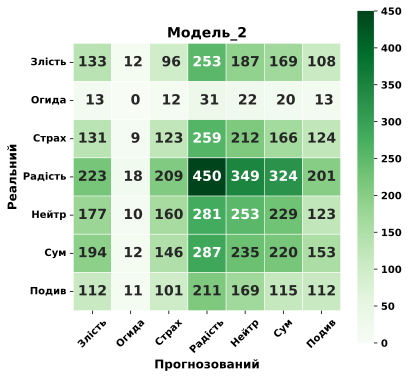

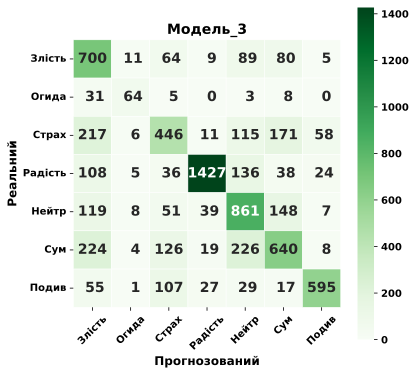

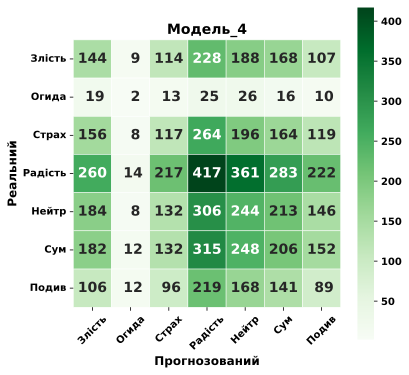

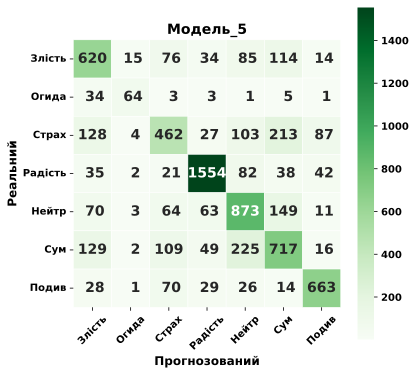

In [5]:
# Loop over each matrix and plot it
for matrix_name, matrix in input_matrices.items():
    plt.figure(figsize=(6,6), dpi=600)

    sns.heatmap(matrix, cmap=PALETTE_HEATMAP, annot=True, xticklabels=EMOTIONS, 
                yticklabels=EMOTIONS, annot_kws={"size": 14, "weight": "bold"}, 
                fmt='3g', square=True, linewidths=0.5, cbar_kws={"shrink": 1.0})

    #plt.tick_params(axis='x', labelsize=12) # x font label size
    #plt.tick_params(axis='y', labelsize=12) # y font label size

    plt.yticks(fontweight='bold', fontsize=10, rotation=0)
    plt.xticks(fontweight='bold', fontsize=10, rotation=45)

    plt.title(matrix_name, fontweight='bold', fontsize=14)
    plt.ylabel('Реальний', fontweight='bold', fontsize=12)
    plt.xlabel('Прогнозований', fontweight='bold', fontsize=12)
        
    if not os.path.exists(FOLDER_HEATMAP):
        os.makedirs(FOLDER_HEATMAP)

    # plt.savefig(f'heatmaps/heatmap_{matrix_name}.png', dpi=600, bbox_inches='tight')
    plt.savefig(f'{FOLDER_HEATMAP}/{DATASET_NAME}_hm_{matrix_name}.svg', 
                format='svg', bbox_inches='tight')
    
    # show the plot
    plt.show()
